In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from minisom import MiniSom
from py_pcha import PCHA
import tqdm
import seaborn as sns

In [2]:
# hr_data = pd.read_csv('data/HR_data.csv')
hr_data = pd.read_csv('data/HR_data_2.csv')
# print(hr_data.columns)
RANDOM = 42

In [3]:
# Helper functions 
def gap_statistic(range_n_clusters, numpy_data):
    def wk(labels, data, k):
        clusters = {i: data[labels == i] for i in range(k)}
        centroids = np.array([np.mean(clusters[i], axis=0) for i in range(k)])
        w_k = 0
        for l in range(k):
            cluster = clusters[l]
            N_l = cluster.shape[0]
            if N_l == 0: continue
            dist = np.linalg.norm(cluster - centroids[l], axis=1)
            D_l = N_l * np.sum(dist**2)
            w_k += D_l / (2 * N_l)
        return w_k

    sim_data_sets = [np.random.uniform(np.min(numpy_data, axis=0), 
                                       np.max(numpy_data, axis=0), 
                                       size=numpy_data.shape) 
                     for _ in range(20)]  

    w_ks, u_ks = [], []
    for k in tqdm.tqdm(range_n_clusters):
        labels = KMeans(n_clusters=k, random_state=RANDOM).fit_predict(numpy_data)
        w_ks.append(wk(labels, numpy_data, k))

        sim_wks = []
        for sim in sim_data_sets:
            sim_labels = KMeans(n_clusters=k, random_state=RANDOM).fit_predict(sim)
            sim_wks.append(wk(sim_labels, sim, k))
        u_ks.append(sim_wks)  
    u_ks = np.array(u_ks)
    w_ks = np.array(w_ks)  # Convert to numpy array

    g_k = np.log(u_ks.mean(axis=1)) - np.log(w_ks)  # Compute gap statistic
    return g_k, u_ks, w_ks  # Return w_ks as well

In [4]:
"""
NOTE: D11 winter, and D12 and D13 were completed in the fall 
D131 and D133 were completed in the morning and D132 and D134 were collected in the evening
"Frustrated" is (Only asked in the task phase) On a scale from 0-10, where 0 is not difficult at all and 10 is extremely difficult, how difficult did you find the task?
there are 312 rows = 26 participants * 4 rounds * 3 phases
"""

# Special columns:
# Round,Phase,Individual,Puzzler,original_ID,raw_data_path,Team_ID,Frustrated,Cohort,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
# Categorical/Ordinal categorical columns: Round,Phase,Individual,Puzzler,original_ID,raw_data_path,Team_ID,Cohort,frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined

# Find missing values
print("There are na values in the data: ", hr_data.isna().sum().sum())
print("The missing values are in the following columns: ", hr_data.isna().sum()[hr_data.isna().sum() > 0].index.tolist())
print("The missing values are in the following rows: ", hr_data[hr_data.isna().sum(axis=1) > 0].index.tolist())

# Replace the missing values with the mode of the column
for col in hr_data.columns:
    if hr_data[col].isna().sum() > 0:
        if hr_data[col].dtype == 'object' or hr_data[col].dtype.name == 'category':
            hr_data[col] = hr_data[col].fillna(hr_data[col].mode()[0])
        else:
            hr_data[col] = hr_data[col].fillna(int(hr_data[col].mode()[0]))

# Get the last element of the string in the column "Phase" and "Round" and make it int
hr_data['Round'] = hr_data['Round'].apply(lambda x: int(x.split('_')[-1]))
hr_data['Phase'] = hr_data['Phase'].apply(lambda x: int(x[-1]))
to_drop = ["Team_ID",'Round', 'Phase', 'original_ID', 'raw_data_path']

hr_data_with_dummies = hr_data.drop(to_drop, axis=1)

# One hot encoding for the string columns
hr_data_with_dummies = pd.get_dummies(hr_data_with_dummies, columns=[ 'Puzzler',"Cohort"], dtype=np.int8)
# hr_data_with_dummies.info()

# Keep all columns except the first column (participant ID) the raw data path column
hr_data_with_dummies = hr_data_with_dummies.iloc[:, 1:]
# hr_data_with_dummies.info()

# Check missing values
print("After there are na values in the data: ", hr_data.isna().sum().sum())
print("After the missing values are in the following columns: ", hr_data.isna().sum()[hr_data.isna().sum() > 0].index.tolist())
print("After the missing values are in the following rows: ", hr_data[hr_data.isna().sum(axis=1) > 0].index.tolist())

There are na values in the data:  9
The missing values are in the following columns:  ['EDA_TD_P_RT', 'EDA_TD_P_ReT', 'inspired', 'attentive', 'afraid', 'active', 'determined']
The missing values are in the following rows:  [104, 120, 122, 125, 272]
After there are na values in the data:  0
After the missing values are in the following columns:  []
After the missing values are in the following rows:  []


Number of components selected by Kaiser criterion: 19
Total variance explained by Kaiser components: 0.8240
Number of PCs needed to explain 80% variance: 18
Number of PCs needed to explain 90% variance: 26


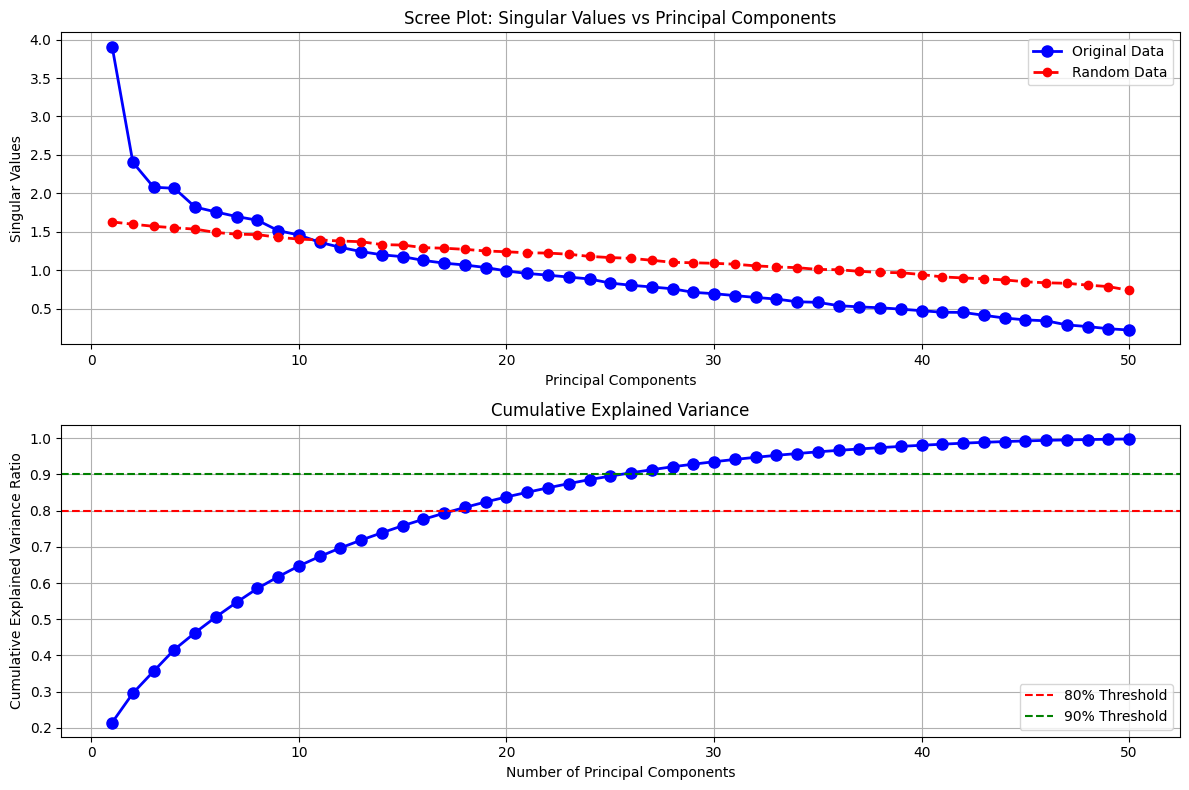

In [5]:
#### PCA ####
scaler = StandardScaler()
numpy_data = hr_data_with_dummies.to_numpy()
scaled_data = scaler.fit_transform(numpy_data)

### Kaiser criterion ###
pca = PCA(n_components=50)
pca.fit(scaled_data)

scaled_data = pca.transform(scaled_data)

eigenvalues = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Apply Kaiser criterion (eigenvalues > 1)
n_components_kaiser = sum(eigenvalues > 1)

print(f"Number of components selected by Kaiser criterion: {n_components_kaiser}")
print(f"Total variance explained by Kaiser components: {cumulative_variance[n_components_kaiser-1]:.4f}")


### Scree plot ###
# Get the singular values and variance explained
singular_values = np.sqrt(pca.explained_variance_)
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

# Create a randomized dataset with the same total variance
np.random.seed(RANDOM)
random_data = np.random.normal(0, 1, size=scaled_data.shape)
total_var_original = np.sum(np.var(scaled_data, axis=0))
total_var_random = np.sum(np.var(random_data, axis=0))
scale_factor = np.sqrt(total_var_original / total_var_random)
random_data *= scale_factor

# Perform PCA on the randomized data
pca_random = PCA()
pca_random.fit(random_data)
singular_values_random = np.sqrt(pca_random.explained_variance_)

plt.figure(figsize=(12, 8))
# Plot 1: Singular values comparison
plt.subplot(2, 1, 1)
plt.plot(range(1, len(singular_values) + 1), singular_values, 'bo-', linewidth=2, markersize=8, label='Original Data')
plt.plot(range(1, len(singular_values_random) + 1), singular_values_random, 'ro--', linewidth=2, markersize=6, label='Random Data')
plt.xlabel('Principal Components')
plt.ylabel('Singular Values')
plt.title('Scree Plot: Singular Values vs Principal Components')
plt.legend()
plt.grid(True)

# Plot 2: Cumulative variance explained
plt.subplot(2, 1, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)

# Find number of components for different thresholds
pc_80 = np.argmax(cumulative_variance >= 0.8) + 1
pc_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of PCs needed to explain 80% variance: {pc_80}")
print(f"Number of PCs needed to explain 90% variance: {pc_90}")
plt.tight_layout()
plt.show()


##  only for the first kasier component
scaled_data = scaled_data[:, :n_components_kaiser]

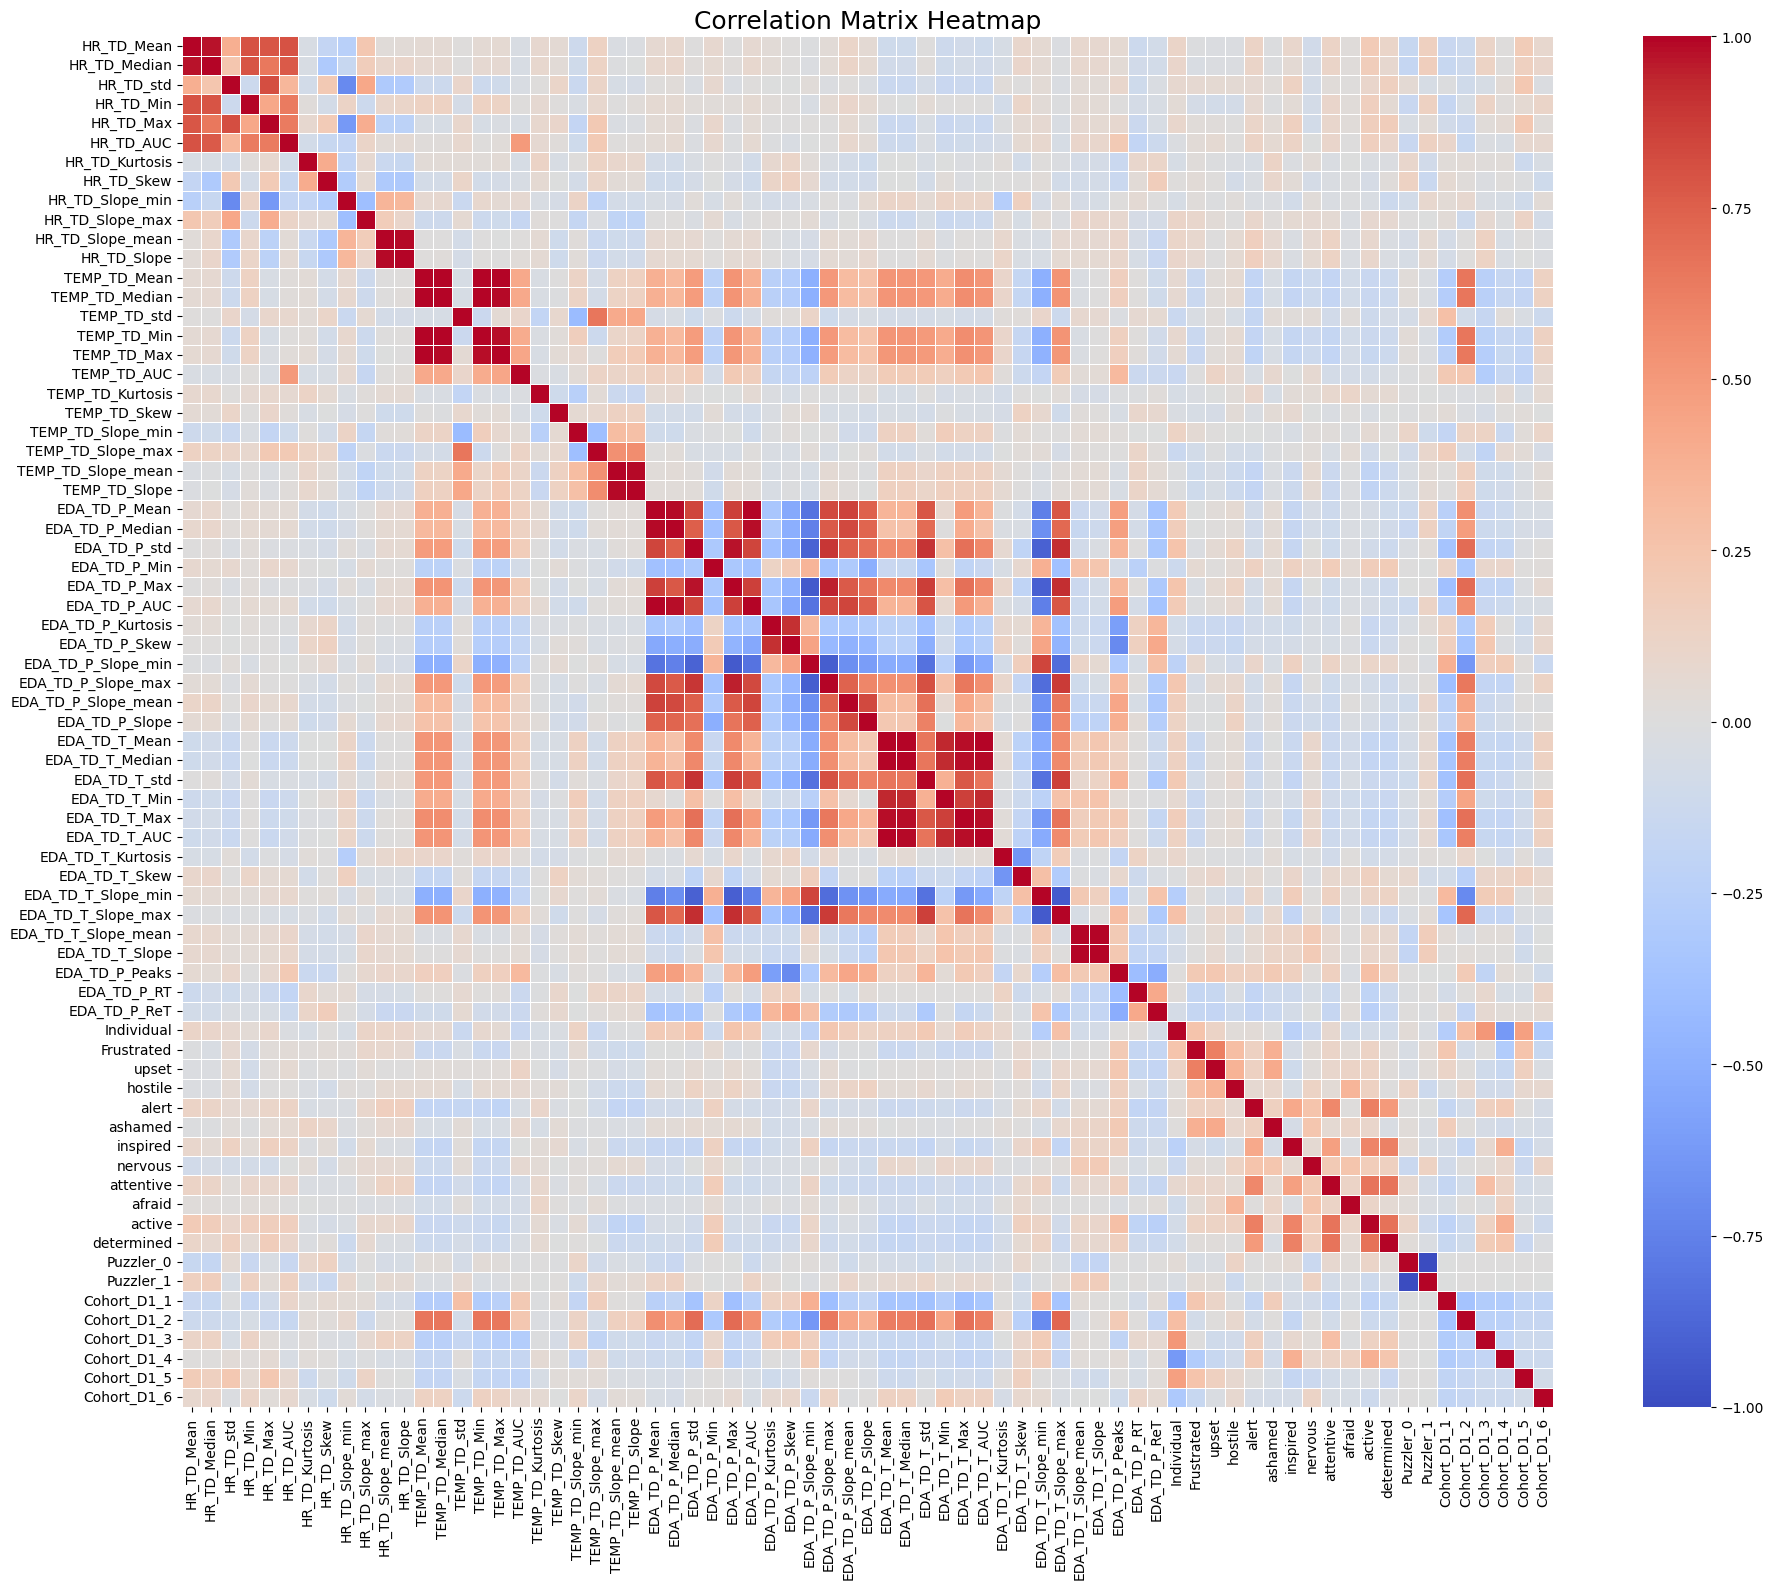

Found 88 feature pairs with correlation > 0.7

Top 10 highest correlations:
Puzzler_0 and Puzzler_1: -1.000
TEMP_TD_Mean and TEMP_TD_Median: 1.000
EDA_TD_T_Mean and EDA_TD_T_Median: 0.999
EDA_TD_P_Mean and EDA_TD_P_AUC: 0.999
EDA_TD_T_Slope_mean and EDA_TD_T_Slope: 0.996
TEMP_TD_Mean and TEMP_TD_Min: 0.996
TEMP_TD_Median and TEMP_TD_Min: 0.995
EDA_TD_T_Mean and EDA_TD_T_AUC: 0.994
TEMP_TD_Mean and TEMP_TD_Max: 0.994
TEMP_TD_Median and TEMP_TD_Max: 0.992


In [6]:

#### Correlation matrix ####
corr_matrix = hr_data_with_dummies.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(20, 16))
# Using seaborn for better visualization
heatmap = sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
                     vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.tight_layout()
plt.show()

# Find and display highly correlated features
threshold = 0.7
high_corr = corr_matrix.where(np.abs(corr_matrix) > threshold)

# Get pairs of features with high correlation (excluding self-correlations)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Display top high correlations
if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} feature pairs with correlation > {threshold}")
    print("\nTop 10 highest correlations:")
    for col1, col2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"{col1} and {col2}: {corr:.3f}")
else:
    print(f"No feature pairs with correlation > {threshold}")

100%|██████████| 59/59 [00:01<00:00, 49.74it/s]


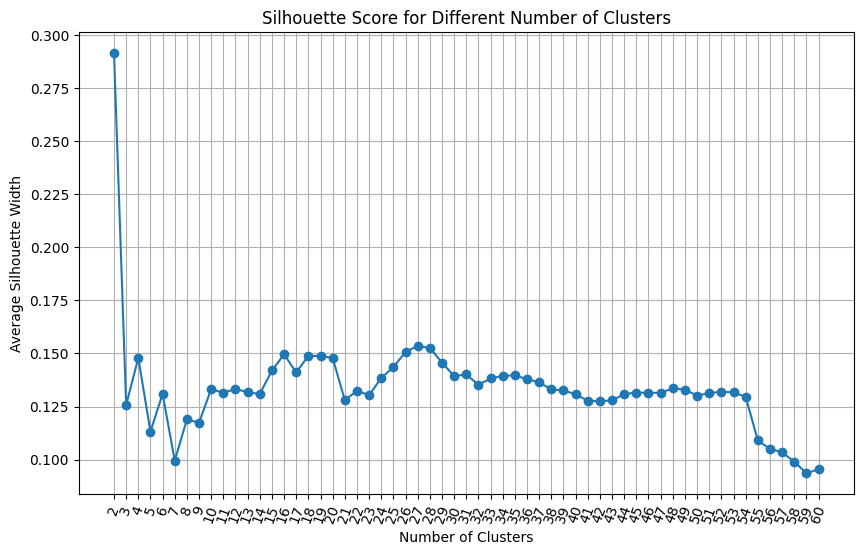

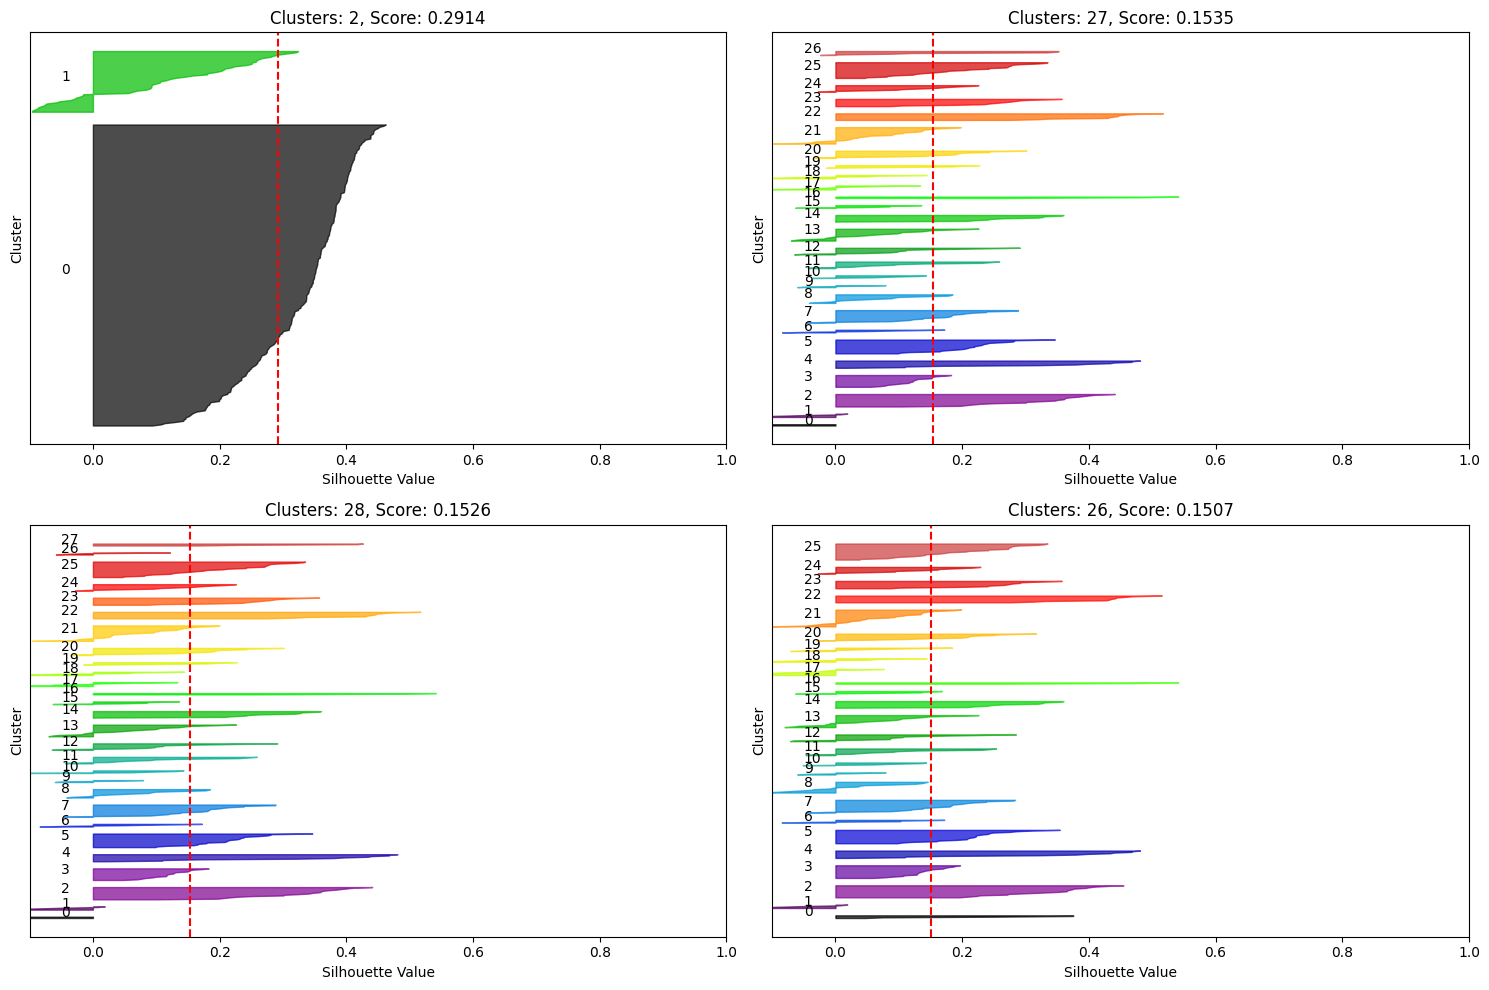

Choice 1, using the maximum average silhouette: 2 with a value of 0.2913747940716686
Choice 2, using the rule that all clusters have average s(i) > overall average:  2


In [7]:
#### Silhouette analysis ####
cluster_range = range(2, 61)
results = []
s_scores = []
for n_clusters in tqdm.tqdm(cluster_range):
    clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOM)
    cluster_labels = clusterer.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_vals = silhouette_samples(scaled_data, cluster_labels)
    
    # Store results
    results.append({
        'n_clusters': n_clusters,
        'score': silhouette_avg,
        'labels': cluster_labels,
        'silhouette_vals': silhouette_vals,
        'clusterer': clusterer  # Optional: store the model if needed later
    })
    s_scores.append(silhouette_avg)


# Plot 1: Silhouette score vs number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, s_scores, marker='o')
plt.xticks(cluster_range, rotation=70)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Width')
plt.title('Silhouette Score for Different Number of Clusters')
plt.grid(True)
plt.show()


# Find the top 4 cluster configurations
top_indices = sorted(range(len(s_scores)), key=lambda i: s_scores[i], reverse=True)[:4]
top_clusters = [results[i] for i in top_indices]

# Plot 2: Silhouette plots for top 4 configurations
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, result in enumerate(top_clusters):
    ax = axs[i]

    n_clusters = result['n_clusters']
    score = result['score']
    cluster_labels = result['labels']
    silhouette_vals = result['silhouette_vals']
    
    y_lower = 10
    for cluster in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == cluster]
        cluster_silhouette_vals.sort()
        
        size_cluster = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster
        
        color = plt.cm.nipy_spectral(float(cluster) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with cluster numbers
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        
        # Update y_lower for next plot
        y_lower = y_upper + 10
        
    # The vertical line for average silhouette score
    ax.axvline(x=score, color="red", linestyle="--")
    ax.set_title(f'Clusters: {n_clusters}, Score: {score:.4f}')
    ax.set_xlabel("Silhouette Value")
    ax.set_ylabel("Cluster")
    ax.set_yticks([])  # Clear the y-axis labels / ticks
    ax.set_xlim([-0.1, 1])

plt.tight_layout()
plt.show()

# Choose K∗ with the maximum average silhouette
best_idx = s_scores.index(max(s_scores))
print(f"Choice 1, using the maximum average silhouette: {cluster_range[best_idx]} with a value of {max(s_scores)}")

# Choose the smallest K such that all clusters have average s(i) > overall average
mean_silhouette = np.mean(s_scores)
print("Choice 2, using the rule that all clusters have average s(i) > overall average: ", 
      cluster_range[next(i for i, score in enumerate(s_scores) if score > mean_silhouette)])

100%|██████████| 59/59 [00:14<00:00,  4.17it/s]


Choice 3, using the gap statistic: 2


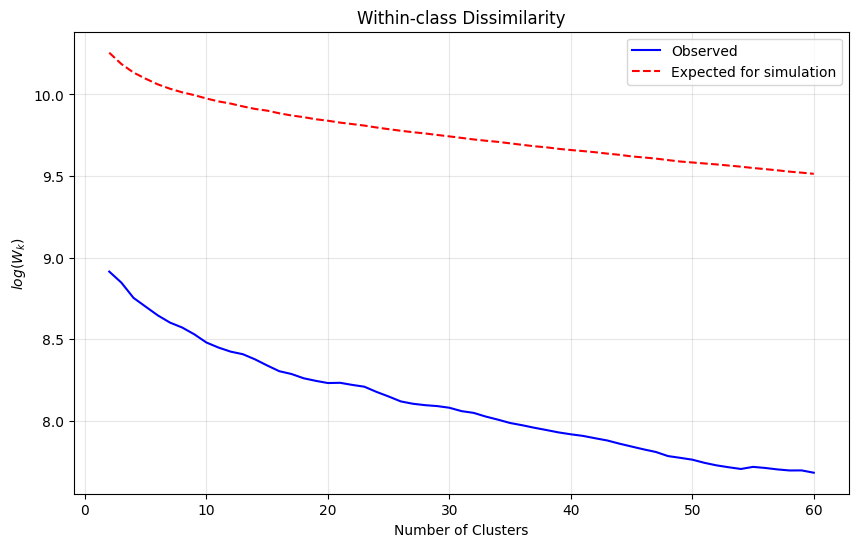

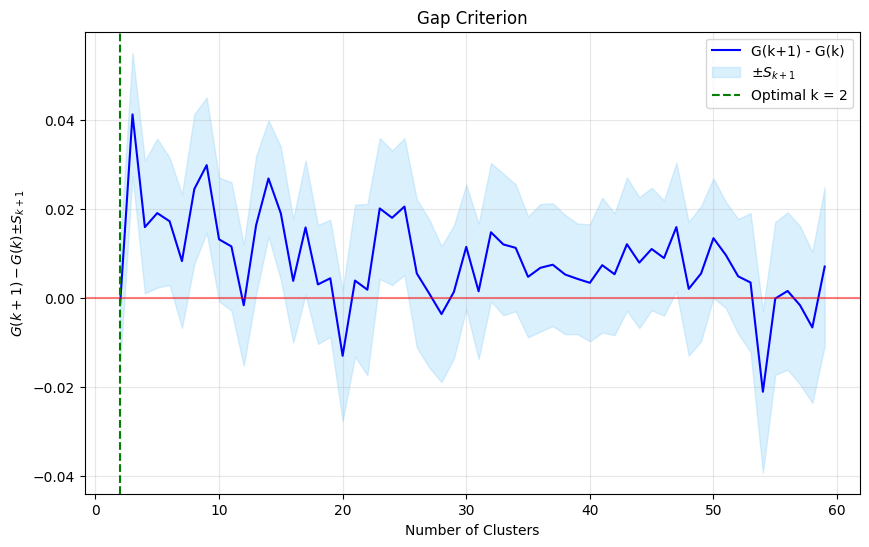

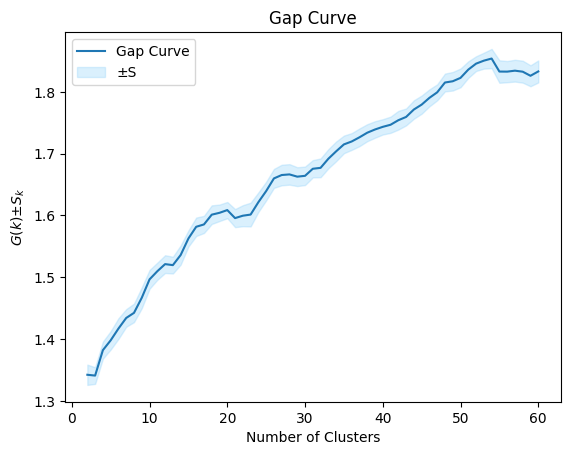

In [8]:
#### Gap statistic ####
g, u, w_ks = gap_statistic(cluster_range, scaled_data)
s = np.std(np.log(u), axis=1) * np.sqrt(1 + 1 / 20)

# Calculate best_k according to the Gap Statistic criterion
best_k = None
for i in range(len(g)-1):
    if g[i] >= g[i+1] - s[i+1]:
        best_k = cluster_range[i]
        break
if best_k is None:
    best_k = cluster_range[-1]  # Default to the largest k if no earlier optimum found
print(f"Choice 3, using the gap statistic: {best_k}")


# Plot 1: Within-class dissimilarity
plt.figure(figsize=(10, 6))
plt.title("Within-class Dissimilarity")
# Plot observed log(W)
plt.plot(cluster_range, np.log(w_ks), 'b-', label='Observed')
# Calculate and plot expected log(W) from reference distribution
Elog_Wu = np.log(u.mean(axis=1))
plt.plot(cluster_range, Elog_Wu, 'r--', label='Expected for simulation')
plt.legend(loc='upper right')
plt.xlabel("Number of Clusters")
plt.ylabel(r"$log(W_k)$")
plt.grid(True, alpha=0.3)
plt.show()


# Plot 2: Gap differential with error bounds
plt.figure(figsize=(10, 6))
plt.title("Gap Criterion")
# Calculate G(k+1) - G(k)
gap_diff = np.zeros(len(g)-1)
for i in range(len(g)-1):
    gap_diff[i] = g[i+1] - g[i]
# Plot G(k+1)-G(k)
plt.plot(cluster_range[:-1], gap_diff, 'b-', label='G(k+1) - G(k)')
# Add error bounds +/- S_{k+1}
plt.fill_between(cluster_range[:-1], 
                gap_diff - s[1:], 
                gap_diff + s[1:], 
                alpha=0.3, color='lightskyblue', 
                label=r'±$S_{k+1}$')
# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)
# Add vertical line at the best k value
plt.axvline(x=best_k, color='g', linestyle='--', label=f'Optimal k = {best_k}')
plt.legend()
plt.xlabel("Number of Clusters")
plt.ylabel(r"$G(k+1) - G(k) ± S_{k+1}$")
plt.grid(True, alpha=0.3)
plt.show()


# Plot 3: Gap statistic with error bounds
plt.plot(cluster_range, g, label='Gap Curve')
plt.fill_between(cluster_range, g - s, g + s, alpha=0.3, color='lightskyblue', label='±S')
plt.xlabel('Number of Clusters')
plt.ylabel(r'$G(k)± S_{k}$')
plt.legend()
plt.title("Gap Curve")
plt.show()

100%|██████████| 59/59 [00:03<00:00, 16.77it/s]


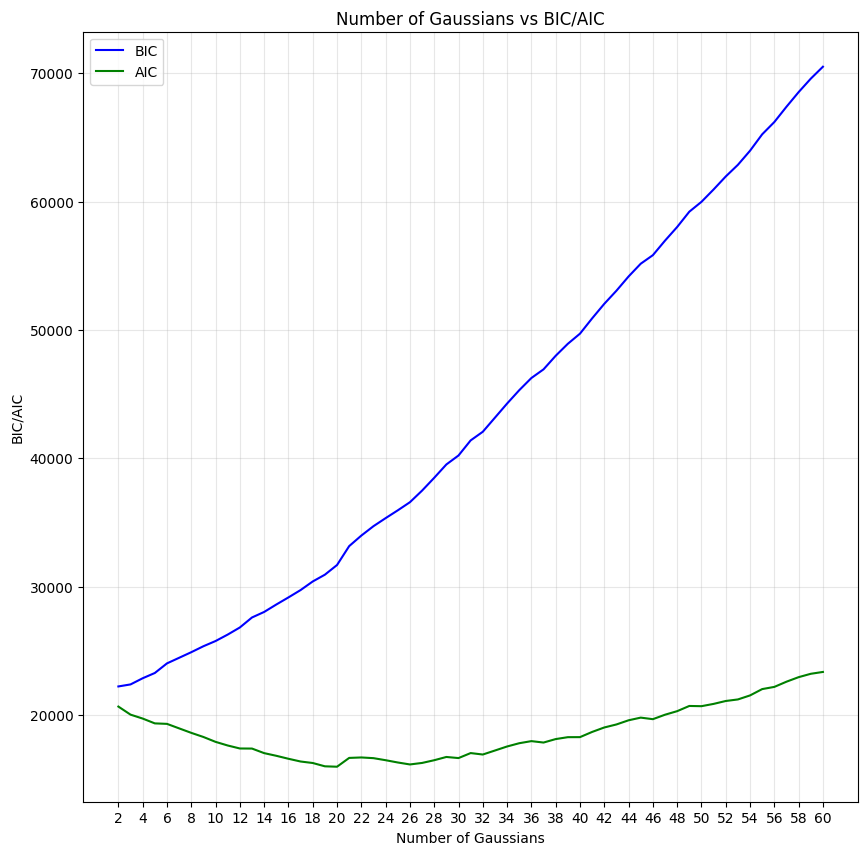

Optimal number of components (BIC): 2
Optimal number of components (AIC): 20


In [9]:
#### GMM ####
n_components_range = range(2, 61)
BIC = np.zeros(len(n_components_range))
AIC = np.zeros(len(n_components_range))

# Investigate AIC + BIC
for i, n_components in enumerate(tqdm.tqdm(n_components_range)):
    # See http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
    gaussMix = GaussianMixture(n_components=n_components, 
                              covariance_type="full", # TODO: tied?
                              reg_covar=0.01,
                              random_state=RANDOM)
    
    # Fit once and use the same model for both metrics
    gaussMix.fit(scaled_data)
    BIC[i] = gaussMix.bic(scaled_data)
    AIC[i] = gaussMix.aic(scaled_data)

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(n_components_range, BIC, c='b', label="BIC")
plt.plot(n_components_range, AIC, c='g', label="AIC")
plt.xlabel("Number of Gaussians")
plt.xticks(range(2, 61, 2))
plt.ylabel("BIC/AIC")
plt.legend()
plt.title("Number of Gaussians vs BIC/AIC")
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Find optimal number of components
optimal_n_components_bic = n_components_range[np.argmin(BIC)]
optimal_n_components_aic = n_components_range[np.argmin(AIC)]

print(f"Optimal number of components (BIC): {optimal_n_components_bic}")
print(f"Optimal number of components (AIC): {optimal_n_components_aic}")

Cophenetic correlation coefficient: 0.458 (closer to 1 is better)


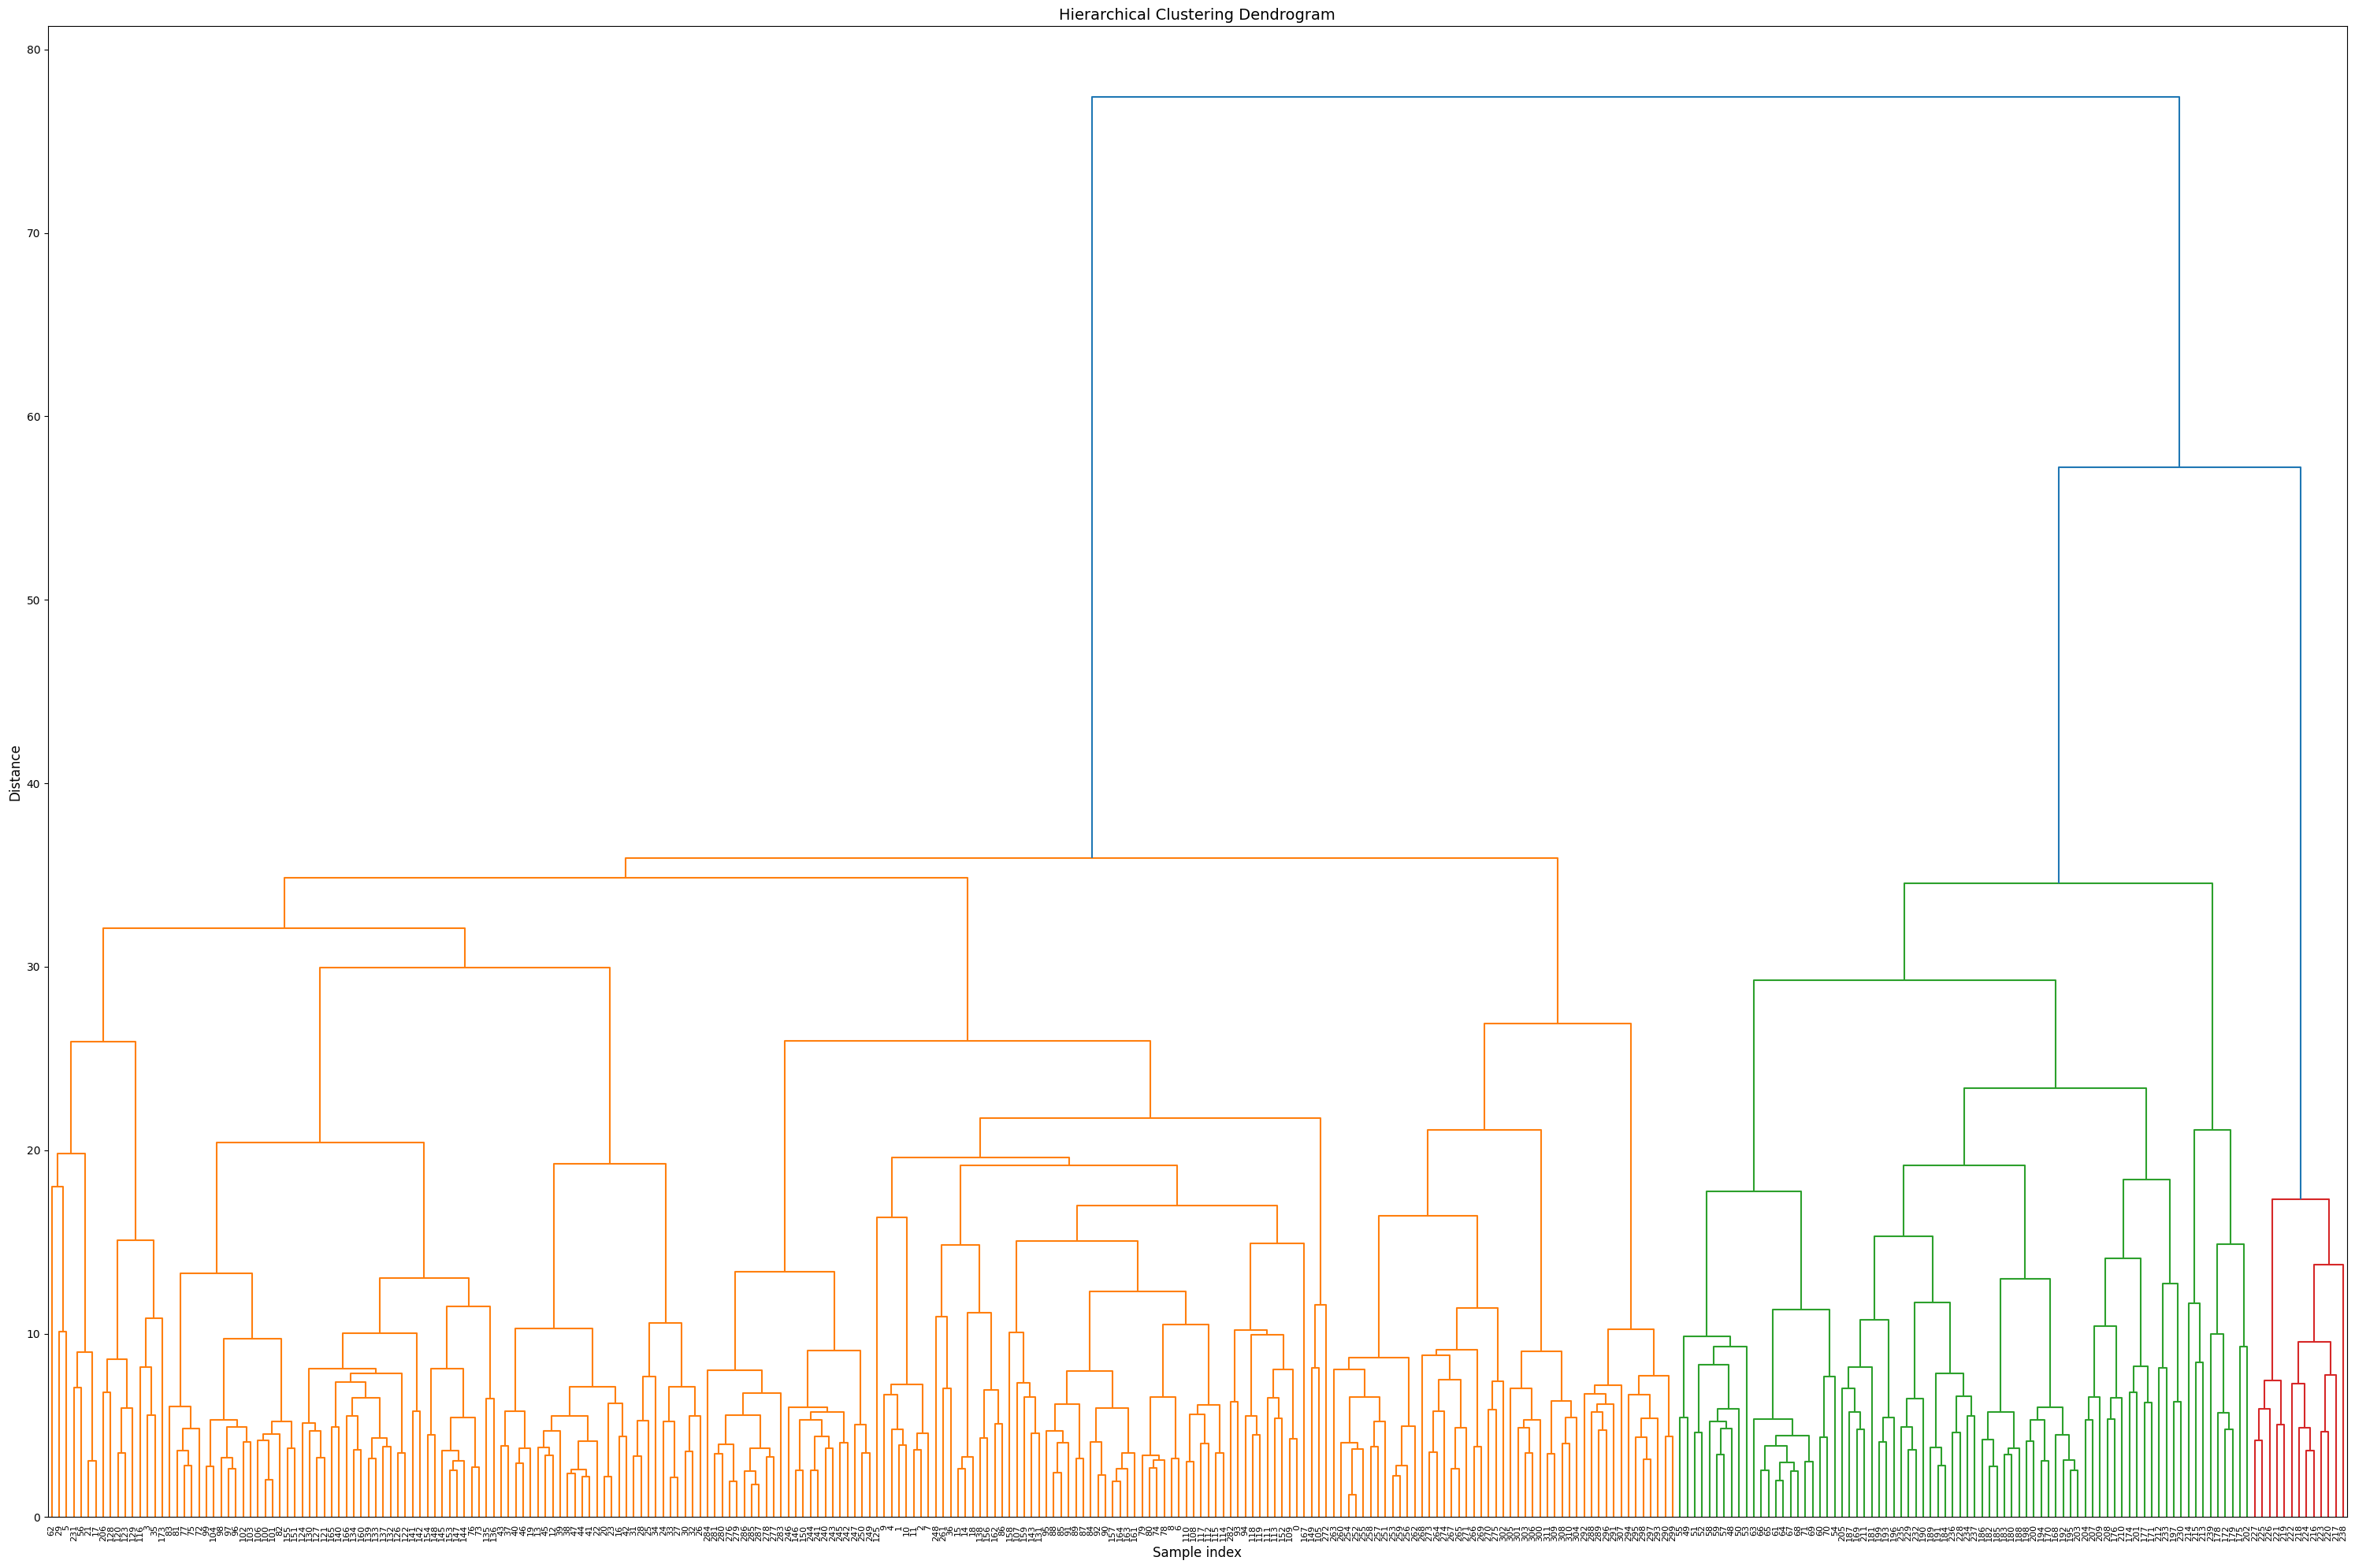

In [10]:
#### Hierarchical clustering ####

# Parameters for clustering
d_sample = 'euclidean'  # Sample distance metric
d_group = 'ward'  # Linkage method
N_leafs = scaled_data.shape[0]

# Perform hierarchical clustering
Z = linkage(scaled_data, method=d_group, metric=d_sample, optimal_ordering=True)

# Calculate cophenetic correlation coefficient to evaluate clustering quality
c, coph_dists = cophenet(Z, pdist(scaled_data, metric=d_sample))
print(f"Cophenetic correlation coefficient: {c:.3f} (closer to 1 is better)")

# Plot full dendrogram
plt.figure(figsize=(30, 20))
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Sample index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p=N_leafs,
)
plt.tight_layout()
plt.show()

Training SOM with grid size (2, 2)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 6.6864, Silhouette score: 0.0505
Training SOM with grid size (3, 3)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 5.9934, Silhouette score: 0.0436
Training SOM with grid size (4, 4)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 5.6469, Silhouette score: 0.0377
Training SOM with grid size (5, 5)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 5.2774, Silhouette score: 0.0840
Training SOM with grid size (6, 6)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 4.8791, Silhouette score: 0.0649
Training SOM with grid size (7, 7)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 4.5819, Silhouette score: 0.0492
Training SOM with grid size (8, 8)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 4.3011, Silhouette score: 0.0530
Training SOM with grid size (9, 9)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 4.0773, Silhouette score: 0.0731
Training SOM with grid size (10, 10)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 3.9395, Silhouette score: 0.0466
Training SOM with grid size (11, 11)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 3.6992, Silhouette score: 0.0201
Training SOM with grid size (12, 12)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 3.5304, Silhouette score: 0.0586
Training SOM with grid size (13, 13)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 3.4029, Silhouette score: 0.0544
Training SOM with grid size (14, 14)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 3.2417, Silhouette score: 0.0277
Training SOM with grid size (15, 15)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 3.0993, Silhouette score: 0.0308
Training SOM with grid size (16, 16)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 2.9533, Silhouette score: 0.0328
Training SOM with grid size (17, 17)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 2.7908, Silhouette score: 0.0460
Training SOM with grid size (18, 18)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 2.6430, Silhouette score: 0.0607
Training SOM with grid size (19, 19)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 2.5267, Silhouette score: 0.0516
Training SOM with grid size (20, 20)...


c:\Users\musti\OneDrive - Danmarks Tekniske Universitet\Masters\Computational Data Analysis\CDA\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


Quantization error: 2.4091, Silhouette score: 0.0392


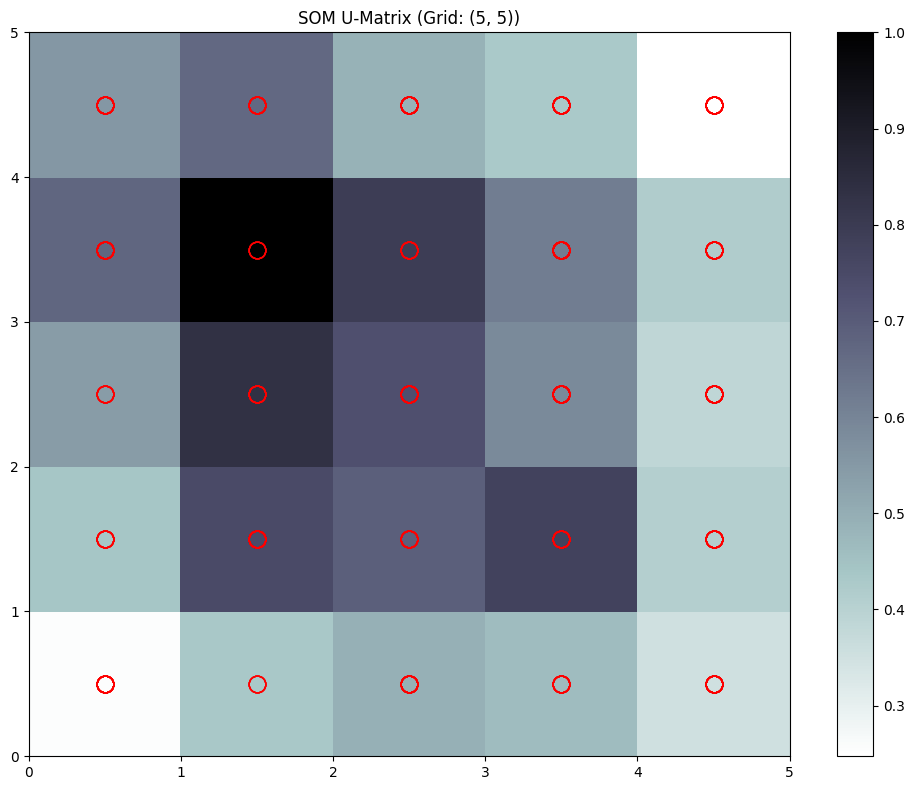

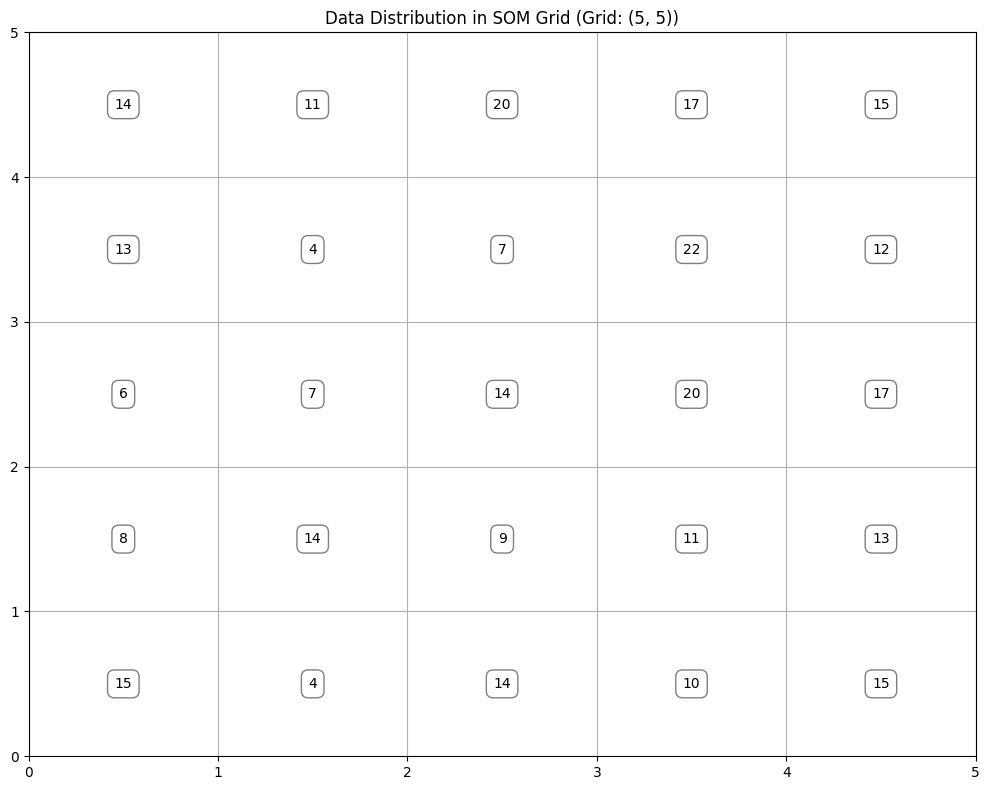

Best SOM grid: (5, 5) with silhouette score: 0.0840


In [11]:
####  Self-Organizing Maps ####
# Define SOM parameters
input_len = scaled_data.shape[1]  # Number of features in the data

# Try different SOM grid sizes
som_shapes = [(n, n) for n in range(2, 21)]  
results = []

for som_shape in som_shapes:
    print(f"Training SOM with grid size {som_shape}...")
    # Initialize SOM
    som = MiniSom(som_shape[0], som_shape[1], input_len, 
                  sigma=2.0,  # Radius of the neighborhood function
                  learning_rate=0.5, 
                  random_seed=RANDOM)
    
    # Initialize weights using PCA for faster convergence
    som.pca_weights_init(scaled_data)
    
    # Train the SOM
    som.train_random(scaled_data, 5000, verbose=False) 
    
    # Calculate winners and quantization error
    winners = np.array([som.winner(x) for x in scaled_data])
    qe = som.quantization_error(scaled_data)
    
    # Convert winners to cluster labels
    cluster_labels = np.array([x[0] * som_shape[1] + x[1] for x in winners])
    
    # Calculate silhouette score if there's more than one cluster
    silhouette_avg = silhouette_score(scaled_data, cluster_labels) if len(np.unique(cluster_labels)) > 1 else 0
    
    results.append({
        'som_shape': som_shape,
        'qe': qe,
        'silhouette': silhouette_avg,
        'som': som,
        'winners': winners,
        'labels': cluster_labels
    })
    print(f"Quantization error: {qe:.4f}, Silhouette score: {silhouette_avg:.4f}")

# Find best SOM based on silhouette score
best_result = max(results, key=lambda x: x['silhouette'])
best_som = best_result['som']
best_shape = best_result['som_shape']
best_winners = best_result['winners']

# Visualize the U-matrix of the best SOM
plt.figure(figsize=(10, 8))
plt.title(f'SOM U-Matrix (Grid: {best_shape})')
plt.pcolor(best_som.distance_map().T, cmap='bone_r')
plt.colorbar()

# Mark winning neurons
for x, y in best_winners:
    plt.plot(x + 0.5, y + 0.5, 'o', markerfacecolor='None', 
             markeredgecolor='red', markersize=12, markeredgewidth=1)

plt.tight_layout()
plt.show()

# Visualize data distribution across neurons
plt.figure(figsize=(10, 8))
plt.title(f'Data Distribution in SOM Grid (Grid: {best_shape})')
for x in range(best_shape[0]):
    for y in range(best_shape[1]):
        cluster_size = np.sum((best_winners[:, 0] == x) & (best_winners[:, 1] == y))
        plt.text(x + 0.5, y + 0.5, str(cluster_size), 
                 ha='center', va='center', 
                 bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))
        
plt.xlim(0, best_shape[0])
plt.ylim(0, best_shape[1])
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best SOM grid: {best_shape} with silhouette score: {best_result['silhouette']:.4f}")


Running Archetypal Analysis for different numbers of archetypes...


100%|██████████| 49/49 [00:40<00:00,  1.21it/s]


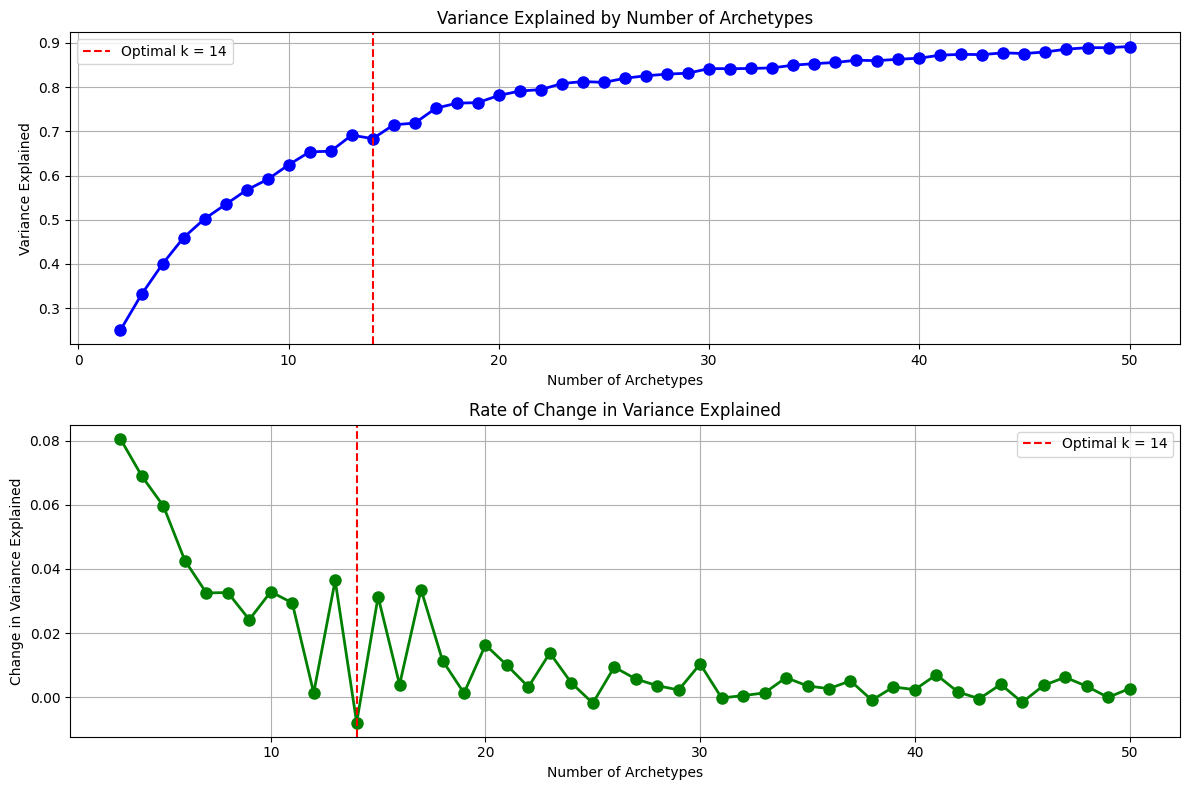

Optimal number of archetypes: 14
Variance explained with 14 archetypes: 0.6836
Optimal archetypes shape: (19, 14)


In [13]:
#### Archetypal Analysis ####
# Run Archetypal Analysis for different numbers of archetypes
results = []
arch_range = range(2, 51)  # Extending the range for better analysis

print("Running Archetypal Analysis for different numbers of archetypes...")
for k in tqdm.tqdm(arch_range):
    # PCHA returns: XC (archetypes), S (coefficients), C (convex combination), SSE (sum of squared errors), varexpl (variance explained)
    XC, S, C, SSE, varexpl = PCHA(scaled_data.T, noc=k, maxiter=1000)
    results.append({
        'k': k,
        'varexpl': varexpl,
        'SSE': SSE,
        'archetypes': XC,  # Store archetypes for later analysis
        'coefficients': S  # Store coefficients for later analysis
    })
    
# Extract variance explained for plotting
varexpl_values = [r['varexpl'] for r in results]

# Calculate the differences in variance explained
varexpl_diffs = [varexpl_values[i+1] - varexpl_values[i] for i in range(len(varexpl_values)-1)]

# Find the elbow point using the maximum second derivative
second_diffs = [varexpl_diffs[i+1] - varexpl_diffs[i] for i in range(len(varexpl_diffs)-1)]
elbow_idx = np.argmin(second_diffs) + 2  # +2 due to offset in arch_range
optimal_k = arch_range[elbow_idx]

# Create a more informative plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(arch_range, varexpl_values, 'o-', linewidth=2, markersize=8, color='blue')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of Archetypes')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Number of Archetypes')
plt.grid(True)
plt.legend()

# Plot the rate of change (first derivative)
plt.subplot(2, 1, 2)
plt.plot(arch_range[1:], varexpl_diffs, 'o-', linewidth=2, markersize=8, color='green')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of Archetypes')
plt.ylabel('Change in Variance Explained')
plt.title('Rate of Change in Variance Explained')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print the results
print(f"Optimal number of archetypes: {optimal_k}")
print(f"Variance explained with {optimal_k} archetypes: {varexpl_values[elbow_idx]:.4f}")

# Use the optimal number of archetypes to visualize results
optimal_result = results[elbow_idx]
optimal_archetypes = optimal_result['archetypes']

# FIX: Check dimensions and create feature indices
feature_indices = np.arange(optimal_archetypes.shape[0])

optimal_result = results[elbow_idx]
optimal_archetypes = optimal_result['archetypes']

# Print shape information for debugging
print(f"Optimal archetypes shape: {optimal_archetypes.shape}")

# Fix: Ensure proper dimensionality for visualization
num_features = optimal_archetypes.shape[0]  # Number of features
num_archetypes = optimal_archetypes.shape[1]  # Number of archetypes
feature_indices = np.arange(num_features)


In [14]:
#### Labeling clusters ####
Best_k = 2

# gaussMix = GaussianMixture(n_components=Best_k, 
#                             covariance_type="tied", # TODO: tied?
#                             reg_covar=0.01,
#                             random_state=RANDOM)
# gaussMix.fit(scaled_data)
# cluster_labels = gaussMix.predict(scaled_data))
cluster_pca = KMeans(n_clusters=Best_k, random_state=RANDOM)
cluster_labels_pca = cluster_pca.fit_predict(scaled_data)

# Add cluster labels to the original data
hr_data['Cluster'] = cluster_labels
# to_count = ['Cohort']
# for cluster in range(Best_k):
#     print(f"Cluster {cluster}:")
#     for col in to_count:
#         counts = hr_data[hr_data['Cluster'] == cluster][col].value_counts()
#         print(f"{col} counts:")
#         for index, count in counts.items():
#             print(f"{index}: {count}")

In [15]:
#### Find important features with Random Forest ####
hr_data_with_dummies['Cluster'] = cluster_labels
y = hr_data_with_dummies["Cluster"]
X = hr_data_with_dummies.drop(columns=["Cluster"])
clf = RandomForestClassifier(n_estimators=10000, random_state=RANDOM,verbose=0, n_jobs=-1)
clf.fit(X, y)
pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature importance ranking:")

imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
for i in range(len(imp)):
    print(f"{i+1}. {imp.index[i]}: {imp.values[i]:.4f}")



Feature importance ranking:
1. HR_TD_Slope_max: 0.0207
2. HR_TD_Min: 0.0196
3. EDA_TD_P_Kurtosis: 0.0195
4. TEMP_TD_std: 0.0189
5. HR_TD_std: 0.0188
6. EDA_TD_P_Skew: 0.0187
7. HR_TD_Mean: 0.0187
8. EDA_TD_T_Slope: 0.0187
9. TEMP_TD_Slope_mean: 0.0187
10. EDA_TD_T_Kurtosis: 0.0186
11. HR_TD_Max: 0.0185
12. TEMP_TD_Skew: 0.0185
13. Individual: 0.0185
14. TEMP_TD_Slope: 0.0183
15. EDA_TD_T_Slope_mean: 0.0183
16. EDA_TD_T_Skew: 0.0182
17. HR_TD_Median: 0.0181
18. TEMP_TD_Slope_max: 0.0180
19. EDA_TD_P_RT: 0.0179
20. EDA_TD_P_Peaks: 0.0177
21. EDA_TD_T_Slope_max: 0.0176
22. HR_TD_Slope_min: 0.0176
23. HR_TD_Kurtosis: 0.0175
24. TEMP_TD_Kurtosis: 0.0175
25. EDA_TD_T_Min: 0.0174
26. TEMP_TD_AUC: 0.0172
27. TEMP_TD_Max: 0.0171
28. TEMP_TD_Slope_min: 0.0171
29. HR_TD_AUC: 0.0171
30. TEMP_TD_Mean: 0.0168
31. HR_TD_Skew: 0.0168
32. EDA_TD_T_std: 0.0167
33. EDA_TD_P_Slope: 0.0166
34. EDA_TD_T_Slope_min: 0.0166
35. TEMP_TD_Min: 0.0165
36. TEMP_TD_Median: 0.0162
37. EDA_TD_P_Median: 0.0159
38. HR_T

<Figure size 1200x1000 with 0 Axes>

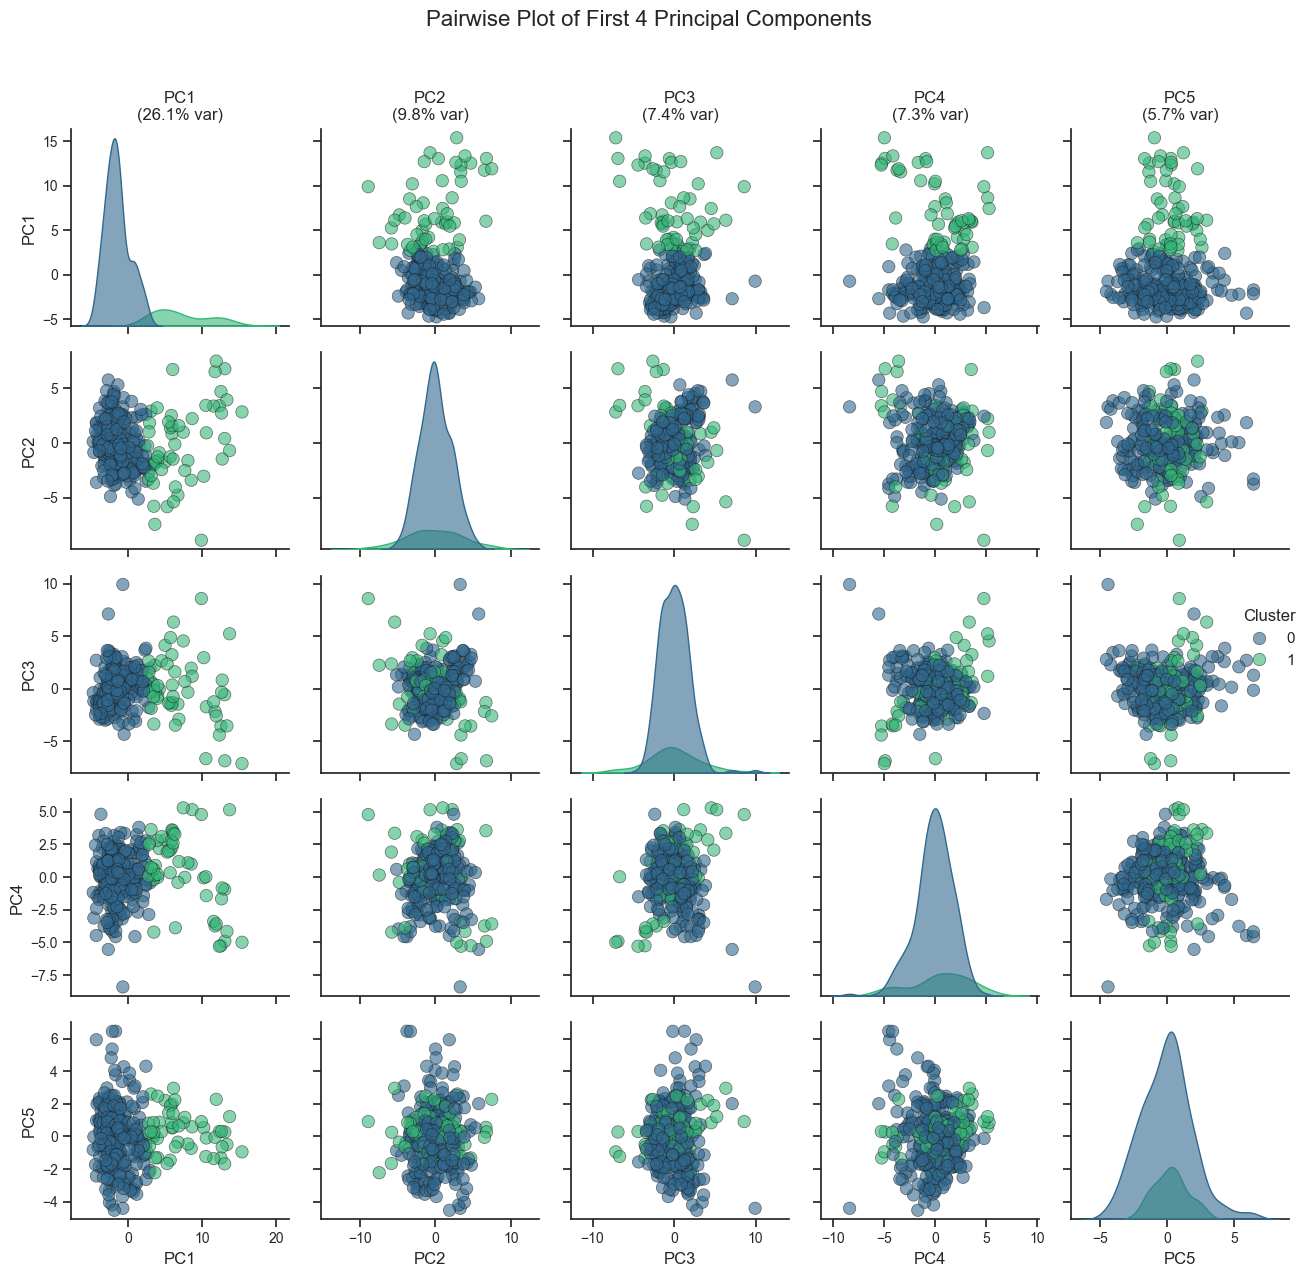

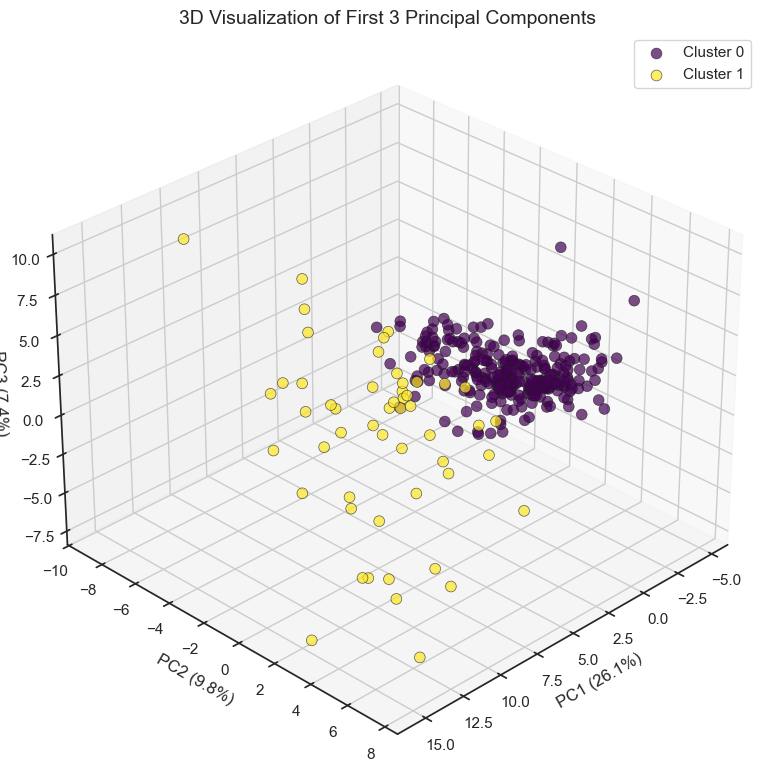

In [16]:
#### Plotting k-means clusters with PCA ####
N = 5  
pca_vis = PCA(n_components=N)
principal_components = pca_vis.fit_transform(scaled_data)
variance_explained = pca_vis.explained_variance_ratio_

# Create a DataFrame with the PCA results
pc_df = pd.DataFrame(
    data=principal_components,
    columns=[f'PC{i+1}' for i in range(N)]
)

# Add cluster labels to the DataFrame
pc_df['Cluster'] = cluster_labels_pca

# Create a pairplot with cluster coloring
plt.figure(figsize=(12, 10))
sns.set(style="ticks")

# Create the pairplot with cluster coloring
g = sns.pairplot(
    pc_df,
    vars=[f'PC{i+1}' for i in range(N)],
    hue='Cluster',
    palette='viridis',
    plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5},
    diag_kind='kde',
    diag_kws={'alpha': 0.6},
    corner=False,
    height=2.5
)
g.fig.suptitle('Pairwise Plot of First 4 Principal Components', y=1.02, fontsize=16)

# Enhance the appearance
for ax in g.axes.flatten():
    ax.tick_params(labelsize=10)
    
# Add variance explained as annotation
for i, ax in enumerate(g.axes[0]):
    if i < N:
        ax.set_title(f'PC{i+1}\n({variance_explained[i]:.1%} var)', fontsize=12)

plt.tight_layout()
plt.show()

# Create a 3D scatter plot of the first 3 components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique clusters for coloring
clusters = np.unique(cluster_labels_pca)
colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))

# Plot each cluster
for cluster_id, color in zip(clusters, colors):
    mask = cluster_labels_pca == cluster_id
    ax.scatter(
        pc_df.loc[mask, 'PC1'],
        pc_df.loc[mask, 'PC2'],
        pc_df.loc[mask, 'PC3'],
        c=[color],
        s=60,
        alpha=0.7,
        edgecolor='k',
        linewidth=0.5,
        label=f'Cluster {cluster_id}'
    )

# Add explanatory labels with variance
ax.set_xlabel(f'PC1 ({variance_explained[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({variance_explained[1]:.1%})', fontsize=12)
ax.set_zlabel(f'PC3 ({variance_explained[2]:.1%})', fontsize=12)
ax.set_title('3D Visualization of First 3 Principal Components', fontsize=14)
ax.legend()

# Add a view angle for better visualization
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()